In [49]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tmu.models.classification.vanilla_classifier import TMClassifier
import time
import matplotlib.patches as patches
import logging

# Set logging level for matplotlib to WARNING or ERROR
logging.getLogger('matplotlib').setLevel(logging.WARNING)


In [50]:
def create_samples_with_centered_reliability(
    num_samples=1000,
    num_values=500,
    std_dev=100,
    min_reliability=0.1,
    max_reliability=1,
    noise_function="sinusoidal"
):
    assert num_samples % 2 == 0, "num_samples should be even to divide equally between classes."
    assert 0 <= min_reliability < max_reliability <= 1, "Reliability must be between 0 and 1, with min < max."

    half_values = num_values // 2
    class_0 = np.hstack((np.ones((num_samples // 2, half_values)), np.zeros((num_samples // 2, half_values))))
    class_1 = np.hstack((np.zeros((num_samples // 2, half_values)), np.ones((num_samples // 2, half_values))))

    matrix = np.vstack((class_0, class_1))
    center = num_values / 2

    # Define different noise intensity functions
    x = np.arange(num_values)
    if noise_function == "exponential":
        noise_intensity = 1 - np.exp(-((x - center) ** 2) / (2 * std_dev ** 2))
    elif noise_function == "linear":
        noise_intensity = np.abs(x - center) / center
    elif noise_function == "quadratic":
        noise_intensity = ((x - center) / center) ** 2
    elif noise_function == "sinusoidal":
        noise_intensity = (1 + np.sin(2 * np.pi * (x / num_values - 0.5))) / 2
    elif noise_function == "uniform":
        noise_intensity = np.ones(num_values)
    else:
        raise ValueError(f"Invalid noise function: {noise_function}")

    # Scale noise intensity to match min and max reliability
    reliability = 1 - noise_intensity
    scaled_reliability = min_reliability + (reliability - reliability.min()) * (max_reliability - min_reliability) / (reliability.max() - reliability.min())
    noise_intensity = 1 - scaled_reliability  # Convert back to noise intensity

    noise_matrix = np.zeros((num_samples, num_values), dtype=int)
    for i in range(num_samples):
        noise_positions = np.random.choice(num_values, size=num_values, p=noise_intensity / np.sum(noise_intensity))
        noise_matrix[i, noise_positions] = 1

    noisy_matrix = np.logical_xor(matrix, noise_matrix).astype(int)
    return noisy_matrix, noise_matrix


In [51]:
num_values=200
num_samples=1000

# Generate dataset
X_train, noise_matrix = create_samples_with_centered_reliability(num_samples=num_samples, num_values=num_values, std_dev=num_values//10)
X_test, noise_matrix = create_samples_with_centered_reliability(num_samples=num_samples, num_values=num_values, std_dev=num_values//10)
Y = (np.repeat([0, 1], len(X_train) // 2)).astype(np.uint32)

In [52]:
def plot_distribution(matrix, noise_matrix):
    noise_distribution = np.sum(noise_matrix, axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.plot(noise_distribution, label='Noise Distribution', marker='x', linestyle='--', color='r')
    plt.title("Noise Distribution Across Positions")
    plt.xlabel("Position")
    plt.ylabel("Sum of 1's (Noise Intensity)")
    plt.legend()
    plt.show()




In [53]:
def count_ta_states(tm):
    number_of_literals = tm.clause_banks[0].number_of_features
    ta_states_array = np.zeros((tm.number_of_classes, 2, tm.number_of_clauses // 2, number_of_literals), dtype=np.uint32)

    for class_idx in range(tm.number_of_classes):
        for polarity in [0, 1]:
            for clause_idx in range(tm.number_of_clauses // 2):
                for bit in range(number_of_literals):
                    action = tm.get_ta_action(clause=clause_idx, ta=bit, the_class=class_idx, polarity=polarity)
                    ta_states_array[class_idx, polarity, clause_idx, bit] = action
    return ta_states_array

def calculate_bit_frequencies_from_ta_states(ta_states):
    global_frequencies = np.zeros(ta_states.shape[-1])
    for class_idx in range(ta_states.shape[0]):
        for polarity in range(ta_states.shape[1]):
            for clause_idx in range(ta_states.shape[2]):
                global_frequencies += ta_states[class_idx, polarity, clause_idx]
    return global_frequencies

def calculate_bit_frequencies_with_polarity(ta_states):
    positive_frequencies = np.zeros(ta_states.shape[-1])  # Polarity 0
    negative_frequencies = np.zeros(ta_states.shape[-1])  # Polarity 1

    for class_idx in range(ta_states.shape[0]):
        for clause_idx in range(ta_states.shape[2]):
            positive_frequencies += ta_states[class_idx, 0, clause_idx]
            negative_frequencies += ta_states[class_idx, 1, clause_idx]

    return positive_frequencies, negative_frequencies

def count_clause_weights(tm, ta_states_array=None):
    if ta_states_array is None:
        ta_states_array = count_ta_states(tm)

    number_of_clauses = tm.number_of_clauses // 2
    number_of_literals = tm.clause_banks[0].number_of_features

    positive_weights = np.zeros(number_of_literals)
    negative_weights = np.zeros(number_of_literals)

    for class_idx in range(tm.number_of_classes):
        for polarity in [0, 1]:
            for clause_idx in range(number_of_clauses):
                weight = tm.get_weight(the_class=class_idx, polarity=polarity, clause=clause_idx)
                
                for bit in range(number_of_literals):
                    # Check if the literal is used in the clause (ta_state is non-zero)
                    if ta_states_array[class_idx, polarity, clause_idx, bit] != 0:
                        if polarity == 0:
                            positive_weights[bit] += weight
                        else:
                            negative_weights[bit] += weight

    return positive_weights, negative_weights

In [54]:
def select_random_bits(total_bits, num_bits):
    return random.sample(range(total_bits), num_bits)

def replace_least_freq(selected_bits, total_bits, bit_frequencies, num_replace):
    selected_bits = list(set(selected_bits))
    
    sorted_bits = np.argsort(bit_frequencies)
    removed_bits = sorted_bits[:num_replace]

    selected_bits = np.delete(selected_bits, removed_bits)    
    remaining_bits = list(set(range(total_bits)) - set(selected_bits))
    if len(remaining_bits) < num_replace:
        raise ValueError("Not enough remaining bits to replace.")
    
    new_bits = random.sample(remaining_bits, num_replace)
    selected_bits = np.append(selected_bits,new_bits)
    
    return selected_bits[:total_bits], removed_bits


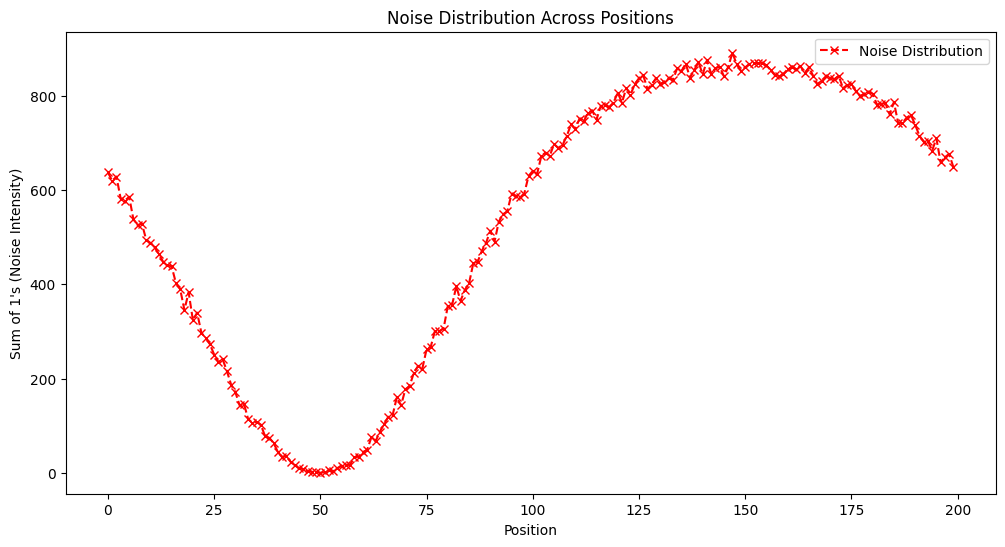

In [55]:
plot_distribution(X_train, noise_matrix)

In [56]:
# Initialize the Tsetlin Machine
epochs = 10
clauses = 30
T = 10
s = 10.0
max_included_literals = 32
tm = TMClassifier(clauses, T, s, max_included_literals=max_included_literals, platform='CPU')

# Random feature selection
num_bits=199
num_replace=1

total_bits=X_train[0].shape[0]
bit_frequencies_history_epoch=np.zeros(total_bits)
selected_bits = select_random_bits(total_bits, num_bits)

bit_frequencies_history = []
positive_frequencies_history = []
negative_frequencies_history = []
positive_weights_history = []
negative_weights_history = []
accuracy_history = []


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")

    X_train_bits = X_train[:, selected_bits]
    #X_test_bits = X_test[:, :, :, selected_bits]
    tm.fit(X_train_bits.astype(np.uint32), Y)
    
    X_test_bits = X_test[:, selected_bits]
    result_test = 100 * (tm.predict(X_test_bits.astype(np.uint32)) == Y).mean()
    accuracy_history.append(result_test)
    ta_states = count_ta_states(tm)
    
    positive_frequencies, negative_frequencies = calculate_bit_frequencies_with_polarity(ta_states)
    positive_weights, negative_weights = count_clause_weights(tm, ta_states)

    positive_frequencies_history.append(positive_frequencies)
    negative_frequencies_history.append(negative_frequencies)
    
    positive_weights_history.append(positive_weights)
    negative_weights_history.append(negative_weights)

    bit_frequencies = calculate_bit_frequencies_from_ta_states(ta_states)
    ta_to_reset = []
    # Translate local index to global
    for org_index, bit_frequency in zip(selected_bits, bit_frequencies):
        bit_frequencies_history_epoch[org_index] = bit_frequency
        #ta_to_reset.append(org_index)
    bit_frequencies_history.append(bit_frequencies_history_epoch.copy())

    
    #selected_bits = range((epoch)*(num_values//epochs), (1+epoch)*(num_values//epochs))
    selected_bits, removed_bits = replace_least_freq(selected_bits, total_bits, bit_frequencies, num_replace)
    # Reset TA state
    for Class in range(tm.number_of_classes):
        for clause in range(tm.number_of_clauses//2):
            for polarity in [0]:
                for ta in ta_to_reset:
                    #print("resetting", Class, clause, polarity, ta)
                    #def set_ta_state(self, clause, ta, state, the_class=0, polarity=0):
                    tm.set_ta_state(clause=clause, ta=ta, state=tm.number_of_state_bits_ta//2, the_class=Class, polarity=polarity)

    
    #result_test = 100 * (tm.predict(X_test_subset) == Y_test_subset).mean()


Epoch 1/10
Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


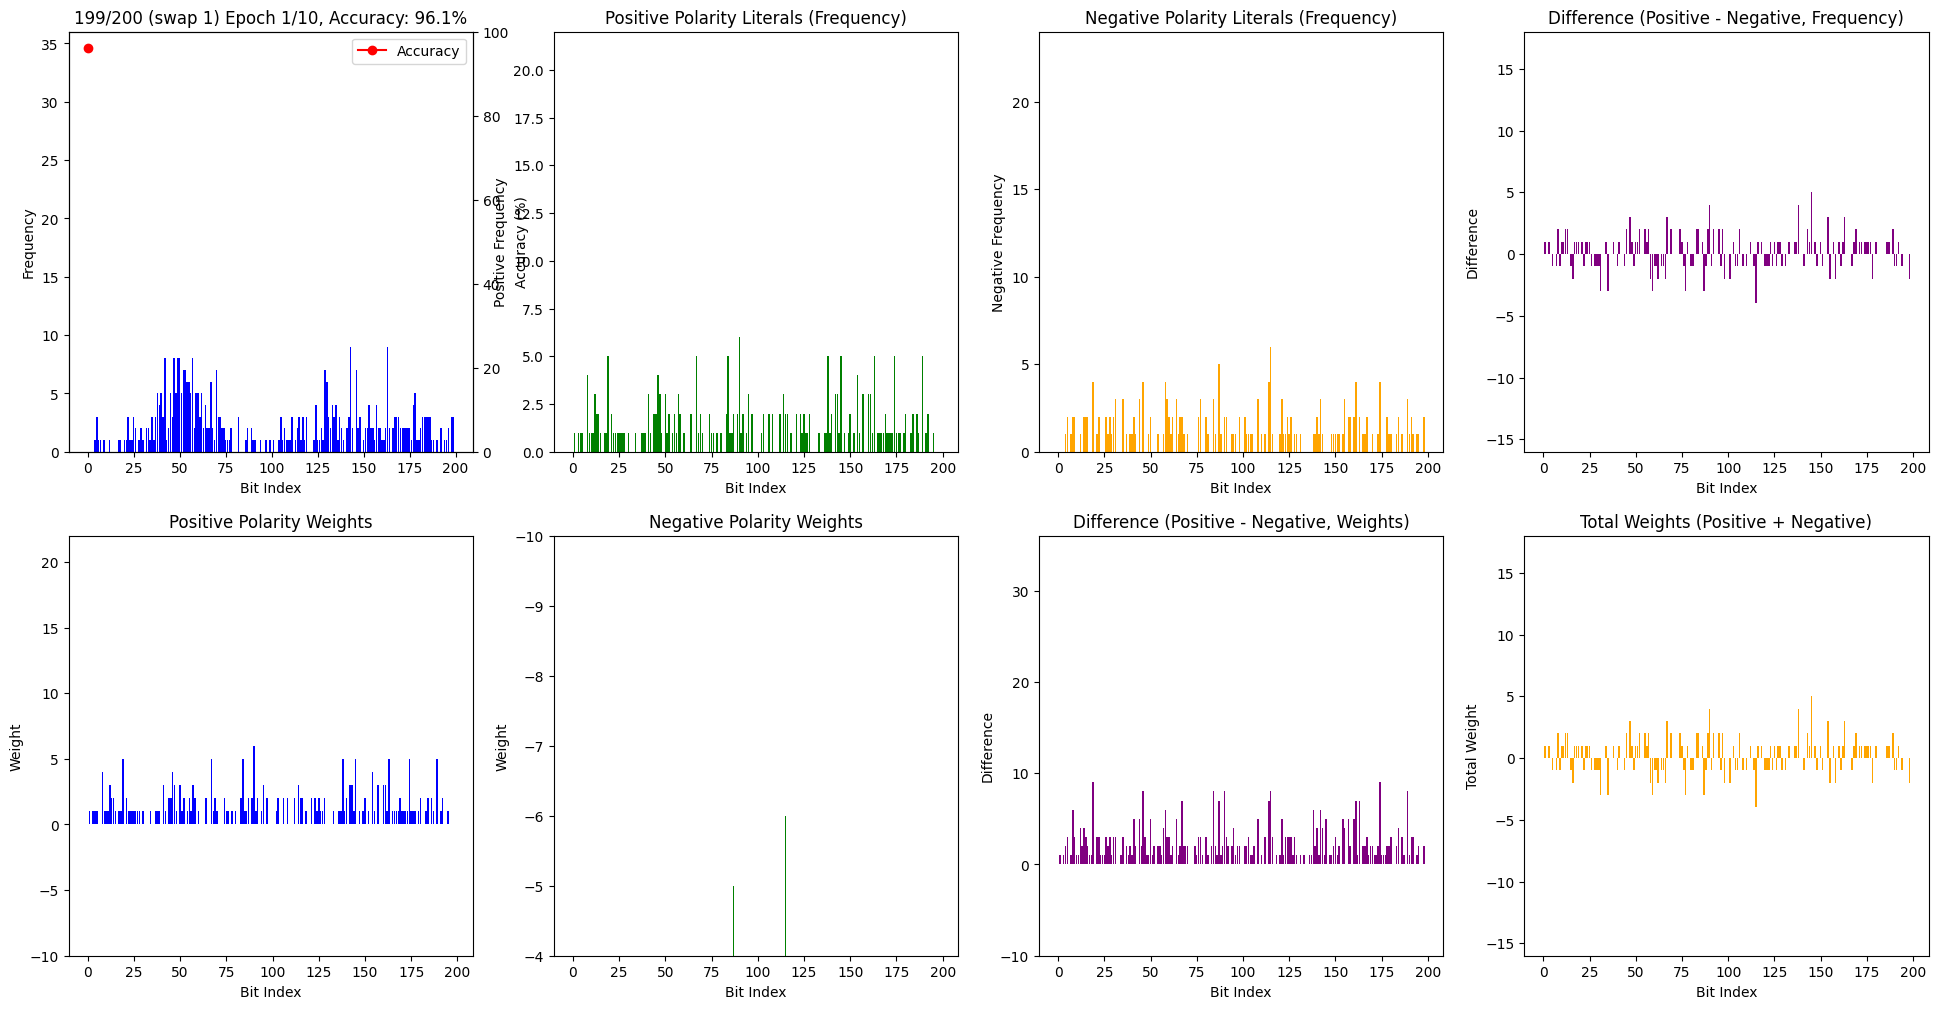

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np

# Number of epochs and features
bit_frequencies_history_epochs = bit_frequencies_history
positive_frequencies_history_epochs = positive_frequencies_history
negative_frequencies_history_epochs = negative_frequencies_history
positive_weights_history_epochs = positive_weights_history
negative_weights_history_epochs = negative_weights_history
epochs = len(bit_frequencies_history_epochs)
num_bits_toShow = len(bit_frequencies_history_epochs[0])

# Setup the figure and axes
fig, axes = plt.subplots(2, 4, figsize=(24, 12))  # 2 rows, 4 columns

# Row 1: Frequencies
ax1, ax2, ax3, ax4 = axes[0]
bars1 = ax1.bar(range(num_bits_toShow), bit_frequencies_history_epochs[0], color='blue')
ax1.set_title('Bit Frequencies and Accuracy Across Epochs')
ax1.set_xlabel('Bit Index')
ax1.set_ylabel('Frequency')
ax1.set_ylim(0, max(max(row) for row in bit_frequencies_history_epochs) + 10)

ax1_2 = ax1.twinx()
accuracy_line, = ax1_2.plot([], [], color='red', marker='o', label='Accuracy')
ax1_2.set_ylabel('Accuracy (%)')
ax1_2.set_ylim(0, 100)
ax1_2.legend(loc='upper right')

bars2 = ax2.bar(range(len(positive_frequencies_history_epochs[0])), positive_frequencies_history_epochs[0], color='green')
ax2.set_title('Positive Polarity Literals (Frequency)')
ax2.set_xlabel('Bit Index')
ax2.set_ylabel('Positive Frequency')
ax2.set_ylim(0, max(max(row) for row in positive_frequencies_history_epochs) + 10)

bars3 = ax3.bar(range(len(negative_frequencies_history_epochs[0])), negative_frequencies_history_epochs[0], color='orange')
ax3.set_title('Negative Polarity Literals (Frequency)')
ax3.set_xlabel('Bit Index')
ax3.set_ylabel('Negative Frequency')
ax3.set_ylim(0, max(max(row) for row in negative_frequencies_history_epochs) + 10)

difference_history_epochs = [
    pos - neg for pos, neg in zip(positive_frequencies_history_epochs, negative_frequencies_history_epochs)
]
bars4 = ax4.bar(range(len(difference_history_epochs[0])), difference_history_epochs[0], color='purple')
ax4.set_title('Difference (Positive - Negative, Frequency)')
ax4.set_xlabel('Bit Index')
ax4.set_ylabel('Difference')
ax4.set_ylim(
    min(min(row) for row in difference_history_epochs) - 10,
    max(max(row) for row in difference_history_epochs) + 10
)

# Row 2: Weights
ax5, ax6, ax7, ax8 = axes[1]
bars5 = ax5.bar(range(len(positive_weights_history_epochs[0])), positive_weights_history_epochs[0], color='blue')
ax5.set_title('Positive Polarity Weights')
ax5.set_xlabel('Bit Index')
ax5.set_ylabel('Weight')
ax5.set_ylim(min(min(row) for row in positive_weights_history_epochs) - 10,
              max(max(row) for row in positive_weights_history_epochs) + 10)

bars6 = ax6.bar(range(len(negative_weights_history_epochs[0])), negative_weights_history_epochs[0], color='green')
ax6.set_title('Negative Polarity Weights')
ax6.set_xlabel('Bit Index')
ax6.set_ylabel('Weight')
ax6.set_ylim(min(min(row) for row in negative_weights_history_epochs) - 10
             , max(max(row) for row in negative_weights_history_epochs) + 10)

difference_weights_epochs = [
    pos - neg for pos, neg in zip(positive_weights_history_epochs, negative_weights_history_epochs)
]
bars7 = ax7.bar(range(len(difference_weights_epochs[0])), difference_weights_epochs[0], color='purple')
ax7.set_title('Difference (Positive - Negative, Weights)')
ax7.set_xlabel('Bit Index')
ax7.set_ylabel('Difference')
ax7.set_ylim(
    min(min(row) for row in difference_weights_epochs) - 10,
    max(max(row) for row in difference_weights_epochs) + 10
)

total_weights_epochs = [
    pos + neg for pos, neg in zip(positive_weights_history_epochs, negative_weights_history_epochs)
]
bars8 = ax8.bar(range(len(total_weights_epochs[0])), total_weights_epochs[0], color='orange')
ax8.set_title('Total Weights (Positive + Negative)')
ax8.set_xlabel('Bit Index')
ax8.set_ylabel('Total Weight')
ax8.set_ylim(
    min(min(row) for row in total_weights_epochs) - 10,
    max(max(row) for row in total_weights_epochs) + 10
)

# Function to update the graphs
def update(epoch):
    # Update Row 1: Frequencies
    for bar, freq in zip(bars1, bit_frequencies_history_epochs[epoch]):
        bar.set_height(freq)
    accuracy_x = np.linspace(0, num_bits_toShow - 1, epochs)
    accuracy_line.set_data(accuracy_x[:epoch + 1], accuracy_history[:epoch + 1])

    for bar, freq in zip(bars2, positive_frequencies_history_epochs[epoch]):
        bar.set_height(freq)

    for bar, freq in zip(bars3, negative_frequencies_history_epochs[epoch]):
        bar.set_height(freq)

    for bar, diff in zip(bars4, difference_history_epochs[epoch]):
        bar.set_height(diff)

    # Update Row 2: Weights
    for bar, weight in zip(bars5, positive_weights_history_epochs[epoch]):
        bar.set_height(weight)

    for bar, weight in zip(bars6, negative_weights_history_epochs[epoch]):
        bar.set_height(weight)

    for bar, diff in zip(bars7, difference_weights_epochs[epoch]):
        bar.set_height(diff)

    for bar, total in zip(bars8, total_weights_epochs[epoch]):
        bar.set_height(total)

    # Update titles
    ax1.set_title(f'{num_bits}/{num_values} (swap {num_replace}) Epoch {epoch + 1}/{epochs}, Accuracy: {round(accuracy_history[epoch], 2)}%')

# Create the animation
ani = FuncAnimation(fig, update, frames=epochs, interval=100)

# Display the animation in the notebook
HTML(ani.to_jshtml())


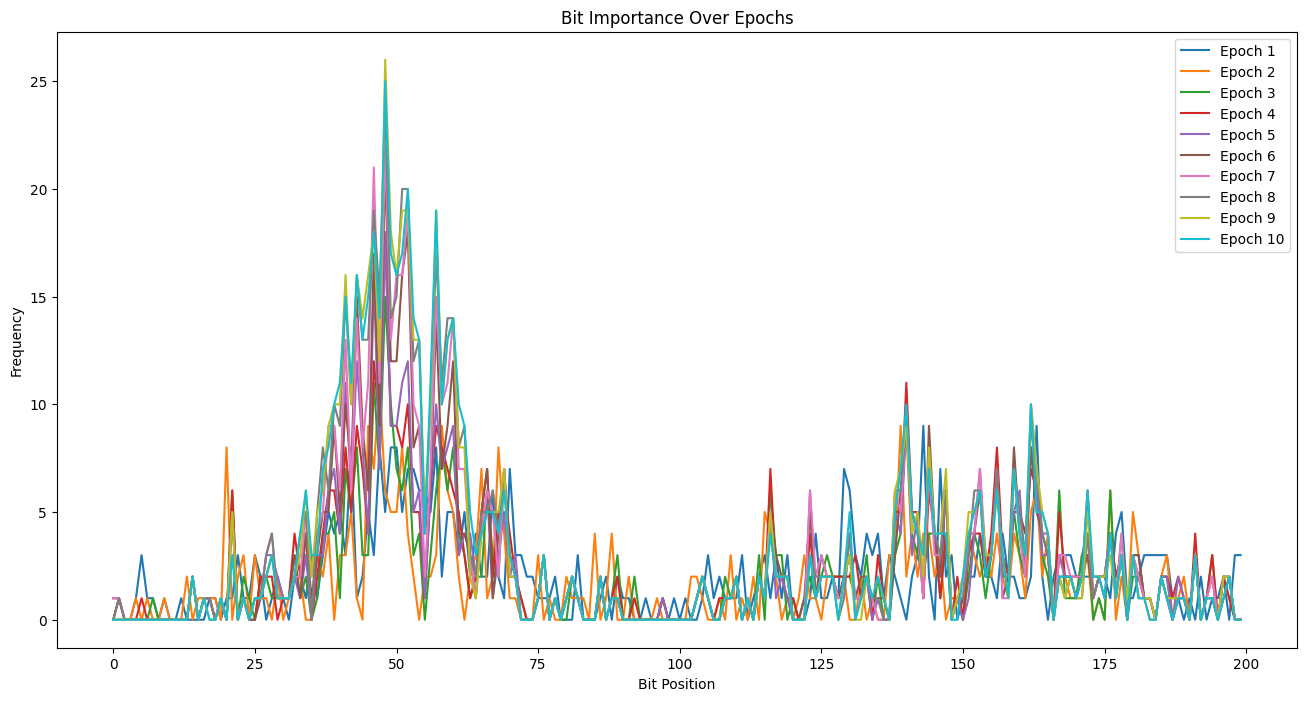

In [58]:
def visualize_bit_importance_over_epochs(bit_frequencies_history):
    epochs = len(bit_frequencies_history)
    total_bits = len(bit_frequencies_history[0])
    
    plt.figure(figsize=(16, 8))
    
    for epoch in range(epochs):
        plt.plot(range(total_bits), bit_frequencies_history[epoch], label=f'Epoch {epoch + 1}')
    
    plt.title("Bit Importance Over Epochs")
    plt.xlabel("Bit Position")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# Visualize bit importance
visualize_bit_importance_over_epochs(bit_frequencies_history)


Collected positive frequencies history: 10
Collected negative frequencies history: 10


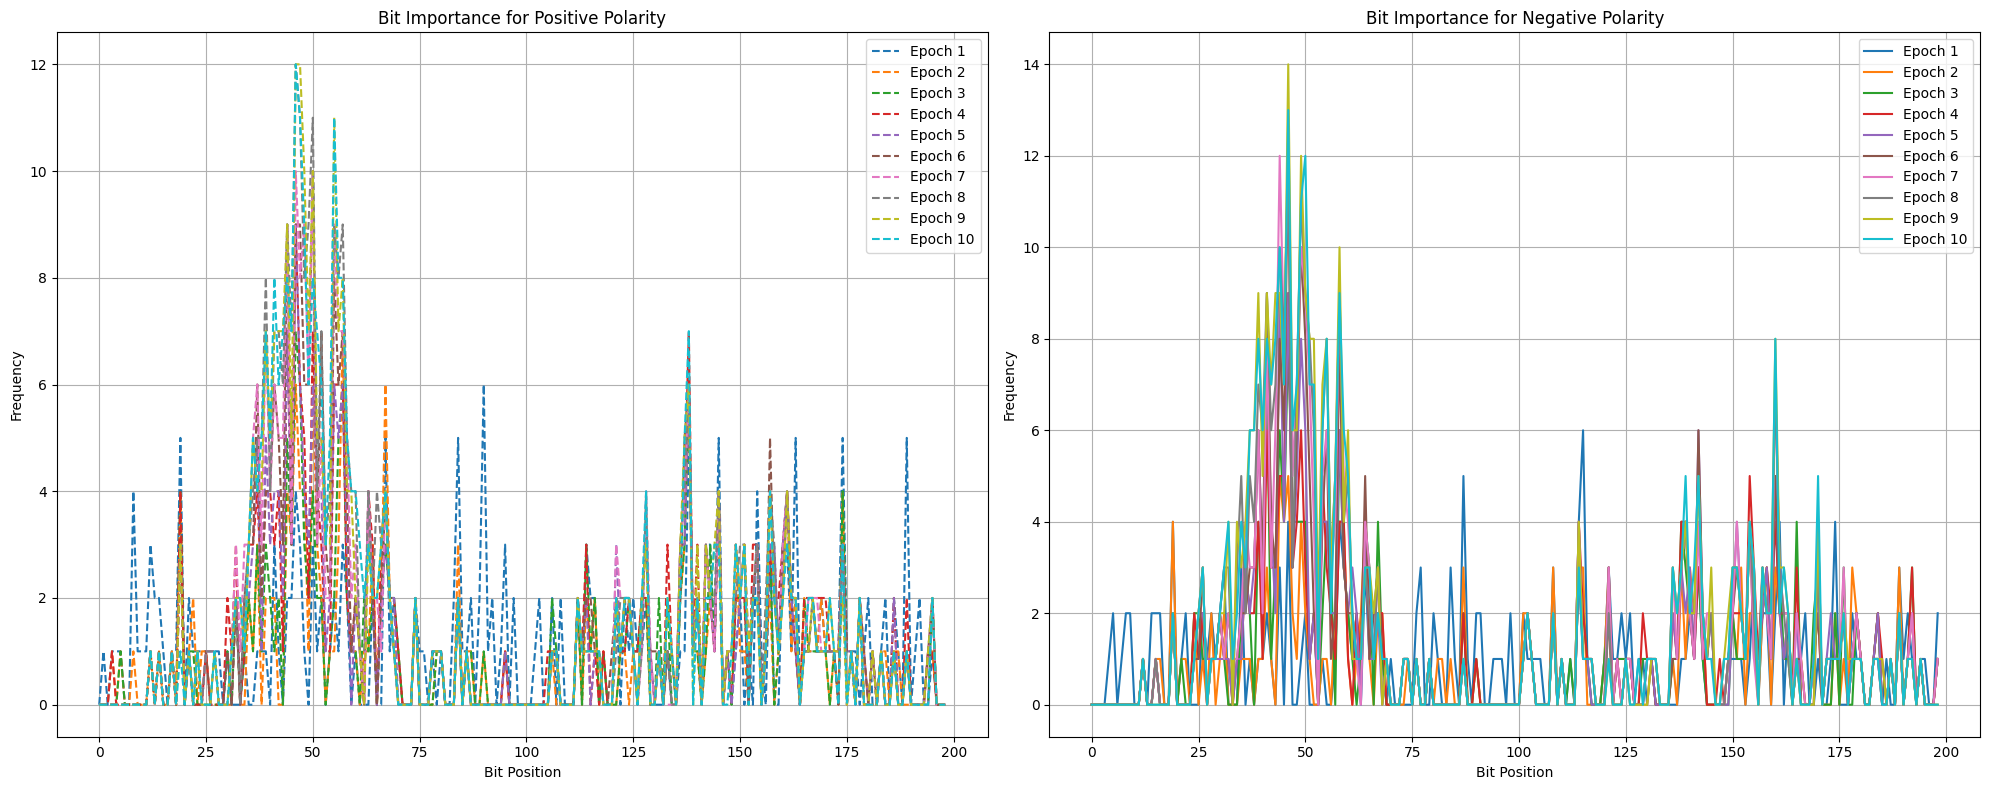

In [59]:
def visualize_bit_importance_with_polarity_side_by_side(positive_frequencies_history, negative_frequencies_history):
    epochs = len(positive_frequencies_history)
    total_bits = len(positive_frequencies_history[0])
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))

    # Plot for Positive Polarity (0)
    ax = axes[0]
    for epoch in range(epochs):
        ax.plot(range(total_bits), positive_frequencies_history[epoch], label=f'Epoch {epoch + 1}', linestyle='--')

    ax.set_title("Bit Importance for Positive Polarity")
    ax.set_xlabel("Bit Position")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid()

    # Plot for Negative Polarity (1)
    ax = axes[1]
    for epoch in range(epochs):
        ax.plot(range(total_bits), negative_frequencies_history[epoch], label=f'Epoch {epoch + 1}', linestyle='-')

    ax.set_title("Bit Importance for Negative Polarity")
    ax.set_xlabel("Bit Position")
    ax.set_ylabel("Frequency")
    ax.legend()
    ax.grid()

    plt.tight_layout()
    plt.show()

# Check the collected data
print("Collected positive frequencies history:", len(positive_frequencies_history))
print("Collected negative frequencies history:", len(negative_frequencies_history))

# Visualize bit importance with side-by-side plots
visualize_bit_importance_with_polarity_side_by_side(positive_frequencies_history, negative_frequencies_history)


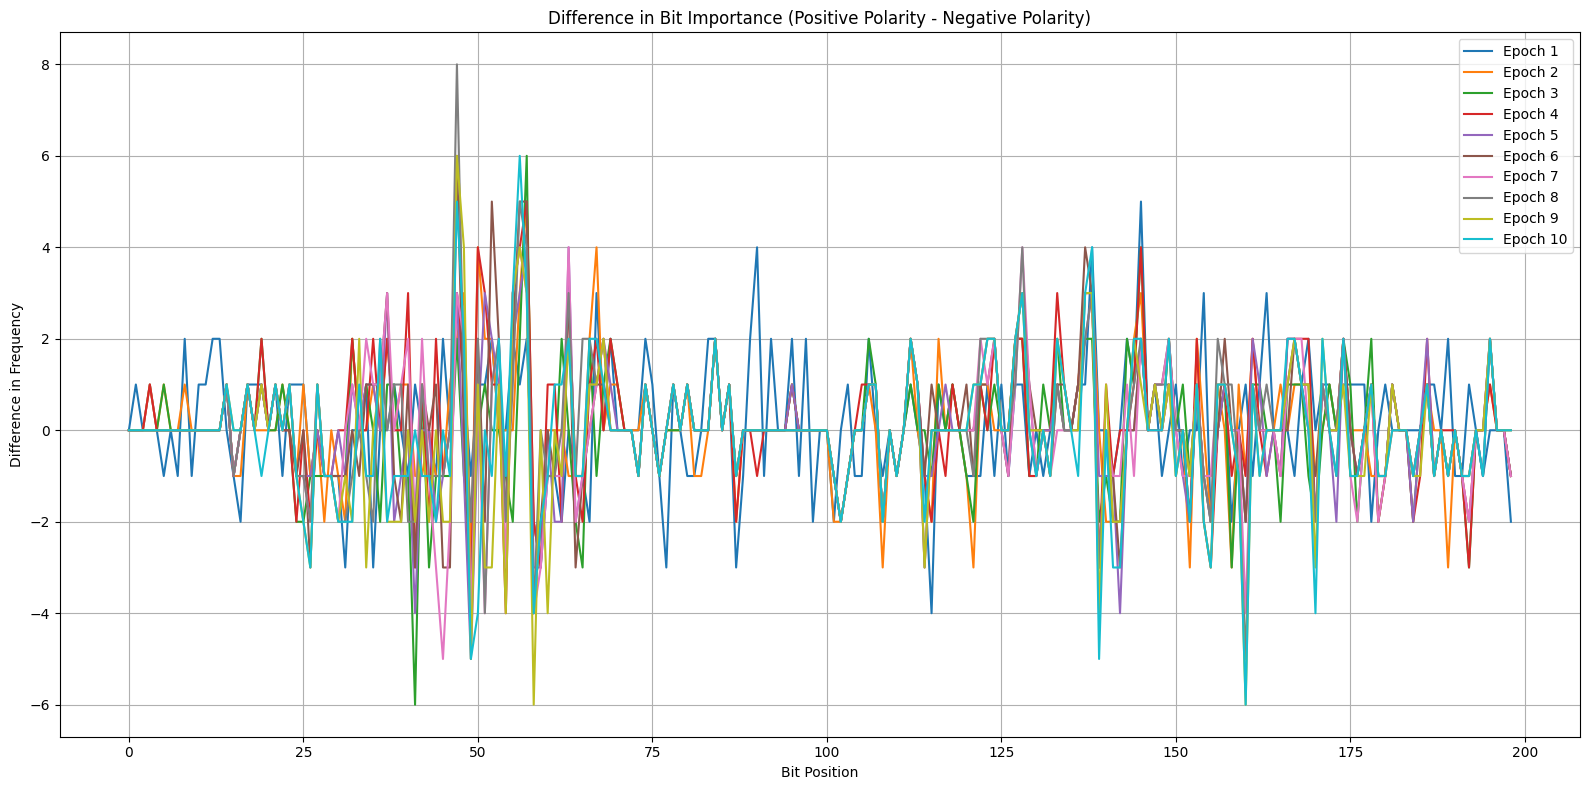

In [60]:
def visualize_difference_in_bit_importance(positive_frequencies_history, negative_frequencies_history):
    epochs = len(positive_frequencies_history)
    total_bits = len(positive_frequencies_history[0])
    
    plt.figure(figsize=(16, 8))

    for epoch in range(epochs):
        # Calculate the difference: Positive - Negative
        difference_frequencies = np.array(positive_frequencies_history[epoch]) - np.array(negative_frequencies_history[epoch])
        
        # Plot the difference for the current epoch
        plt.plot(range(total_bits), difference_frequencies, label=f'Epoch {epoch + 1}', linestyle='-')

    plt.title("Difference in Bit Importance (Positive Polarity - Negative Polarity)")
    plt.xlabel("Bit Position")
    plt.ylabel("Difference in Frequency")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

# Visualize the difference in bit importance between positive and negative polarity
visualize_difference_in_bit_importance(positive_frequencies_history, negative_frequencies_history)


In [61]:
print("Final bit frequencies:")
print(bit_frequencies_history[-1])


Final bit frequencies:
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  2.  0.  1.  0.
  0.  1.  0.  3.  0.  1.  0.  1.  1.  2.  3.  1.  1.  1.  2.  4.  6.  3.
  3.  7.  8. 10. 11. 15. 11. 16. 13. 15. 18. 14. 25. 17. 16. 17. 20. 14.
 13.  4. 11. 19. 10. 13. 14. 10.  9.  5.  3.  4.  5.  5.  4.  6.  3.  2.
  0.  0.  0.  1.  3.  0.  1.  0.  1.  2.  1.  0.  0.  0.  2.  0.  1.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  2.  1.  0.  0.
  1.  1.  2.  0.  1.  0.  2.  1.  4.  2.  2.  2.  0.  0.  0.  3.  1.  2.
  2.  2.  0.  2.  5.  0.  1.  2.  1.  2.  1.  0.  5.  7. 10.  5.  4.  3.
  7.  4.  4.  4.  0.  0.  2.  4.  5.  6.  2.  3.  6.  3.  1.  7.  4.  3.
 10.  5.  5.  4.  0.  2.  2.  2.  1.  2.  6.  2.  2.  1.  4.  1.  3.  0.
  3.  1.  1.  0.  0.  2.  1.  0.  1.  1.  0.  3.  0.  1.  1.  0.  1.  2.
  0.  0.]
